In [335]:
import numpy as np 
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets, transforms


random_seed = 42
torch.backends.cudnn.enabled = False
#torch.manual_seed(random_seed)

In [336]:
pose_data = loadmat('pose.mat')

pose_data['pose'].shape

poses = np.zeros((884,1,48, 40))
for i in range(0,884):
    poses[i,0] = pose_data['pose'][:,:,i%13,i//13]

train_poses = np.zeros((680,1,48, 40))
test_poses = np.zeros((204,1,48, 40))

train_poses_Y = np.zeros((680))
test_poses_Y = np.zeros((204))

TRAIN=10
TEST=13-TRAIN

for i in range(0,68):
    train_poses[TRAIN*i:TRAIN*i+TRAIN] = poses[13*i:13*i+TRAIN]
    test_poses[TEST*i:TEST*i+TEST] =  poses[13*i+TRAIN:13*i+13]
    train_poses_Y[TRAIN*i:TRAIN*i+TRAIN] = i
    test_poses_Y[TEST*i:TEST*i+TEST] = i
    
train_tensor_X = torch.from_numpy(train_poses)
test_tensor_X = torch.from_numpy(test_poses)

train_tensor_Y = torch.from_numpy(train_poses_Y)
test_tensor_Y = torch.from_numpy(test_poses_Y)

trainset = torch.utils.data.TensorDataset(train_tensor_X, train_tensor_Y)
testset = torch.utils.data.TensorDataset(test_tensor_X, test_tensor_Y)

In [443]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3,  stride=1, padding=1)
        self.conv3 = nn.Conv2d(20, 32, kernel_size=3,  stride=1, padding=1)
        self.fc1 = nn.Linear(3840, 600)
        self.fc2 = nn.Linear(600, 68)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 3840)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3840, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=68, bias=True)
)


Train Epoch: 0 [0/680 (0%)]	Loss: 9.440721
Train Epoch: 1 [0/680 (0%)]	Loss: 4.499890
Train Epoch: 2 [0/680 (0%)]	Loss: 4.392668
Train Epoch: 3 [0/680 (0%)]	Loss: 4.269879
Train Epoch: 4 [0/680 (0%)]	Loss: 4.227011
Train Epoch: 5 [0/680 (0%)]	Loss: 4.230580
Train Epoch: 6 [0/680 (0%)]	Loss: 4.206263
Train Epoch: 7 [0/680 (0%)]	Loss: 4.196024
Train Epoch: 8 [0/680 (0%)]	Loss: 4.240953
Train Epoch: 9 [0/680 (0%)]	Loss: 4.223473
Train Epoch: 10 [0/680 (0%)]	Loss: 4.207364
Train Epoch: 11 [0/680 (0%)]	Loss: 4.203915
Train Epoch: 12 [0/680 (0%)]	Loss: 4.203181
Train Epoch: 13 [0/680 (0%)]	Loss: 4.159633
Train Epoch: 14 [0/680 (0%)]	Loss: 4.139135
Train Epoch: 15 [0/680 (0%)]	Loss: 4.141639
Train Epoch: 16 [0/680 (0%)]	Loss: 4.146188
Train Epoch: 17 [0/680 (0%)]	Loss: 4.191238
Train Epoch: 18 [0/680 (0%)]	Loss: 4.178351
Train Epoch: 19 [0/680 (0%)]	Loss: 4.186845
Train Epoch: 20 [0/680 (0%)]	Loss: 4.108643
Train Epoch: 21 [0/680 (0%)]	Loss: 4.124951
Train Epoch: 22 [0/680 (0%)]	Loss: 4.20141

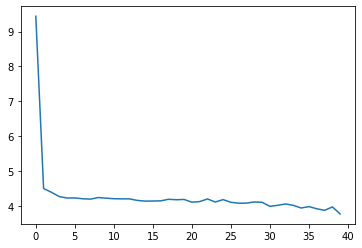

In [462]:
LEARNING_RATE=0.0001
MOMENTUM=0.9
LOG_INTERVAL=100
EPOCHS=40
BATCH_SIZE=128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

poses_net = Net()

optimizer = optim.SGD(poses_net.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM)
train_losses = []
train_counter = []

def train(epoch):
    poses_net.train()
    for idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad() 
        output = poses_net(data.float())
        loss = F.cross_entropy(output, target.long())
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, idx * len(data), len(trainloader.dataset), 100. * idx / len(trainloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((idx*BATCH_SIZE) + ((epoch-1)*len(trainloader.dataset)))

for i in range(0,EPOCHS):
    train(i)
    
plt.plot(train_losses)

In [463]:
test_losses = []

def test():
    poses_net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(testloader):
            output = poses_net(data.float())
            test_loss += F.cross_entropy(output, target.long(), size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))   

test()


Test set: Avg. loss: 3.9526, Accuracy: 24/204 (12%)

